In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import re
from googletrans import Translator, LANGUAGES

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(1)

In [3]:
def count_label_occurences(df, labels, subclasses=None):
    if subclasses:
        count = {label: {subclass: 0 for subclass in subclasses} for label in labels}
    else:
        count = {label: 0 for label in labels}

    for i in range(df.shape[0]):
        data = df.iloc[i]
        for label in labels:
            if subclasses:
                count[label][data[label]] += 1
            elif data[label] == 1:
                count[label] += 1

    return count

In [4]:
def verify_imbalance_ratio(y):
    """
    Verify and print the imbalance ratio for each label
    
    args
    y: pandas.DataFrame, target vector dataframe
    
    return
    imbalance_ratios: dict, imbalance ratio for each label
    mean_ratio: float, mean imbalance ratio across all labels
    """
    print("Imbalance ratios:")
    imbalance_ratios = {}
    finite_ratios = []
    
    for col in y.columns:
        counts = y[col].value_counts()
        # If the label has both 0 and 1
        if 0 in counts.index and 1 in counts.index:
            ratio = counts[0] / counts[1]
            imbalance_ratios[col] = ratio
            finite_ratios.append(ratio)
            print(f"{col}: {ratio:.2f}")
        else:
            if 1 not in counts.index:
                print(f"{col}: No minority samples (ratio = inf)")
                imbalance_ratios[col] = np.inf
            else:
                print(f"{col}: No majority samples (ratio = 0)")
                imbalance_ratios[col] = 0
                finite_ratios.append(0)
    
    # Calculate mean of finite ratios
    if finite_ratios:
        mean_ratio = np.mean(finite_ratios)
        print(f"Mean imbalance ratio: {mean_ratio:.2f}")
    else:
        mean_ratio = np.inf
        print("Mean imbalance ratio: inf (no finite ratios)")
    
    return imbalance_ratios, mean_ratio

In [5]:
def plot_data(label_count):
    # Plot configuration
    x = np.arange(0,4)

    fig, ax = plt.subplots(figsize=(12, 6))

    rects = ax.bar(x, label_count.values())
    ax.bar_label(rects, padding=4)

    # Customization
    ax.set_xlabel('Categories')
    ax.set_ylabel('Counts')
    ax.set_title('Netifier')
    ax.set_xticks(x)
    ax.set_xticklabels(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'])

    # Show the chart
    plt.show()

In [6]:
async def back_translate_async(texts, target_lang='en', original_lang='id'):
    """
    Performs back-translation for batch of texts.
    """
    async with Translator() as translator:
        translated_obj = await translator.translate(texts, dest=target_lang, src=original_lang)
        translated_text = [trans.text for trans in translated_obj]

        back_translated_obj = await translator.translate(translated_text, dest=original_lang, src=target_lang)
        return [trans.text.lower().strip() for trans in back_translated_obj]

Index(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'], dtype='object')
{'pornografi': 1747, 'sara': 1238, 'radikalisme': 1276, 'pencemaran_nama_baik': 2425}


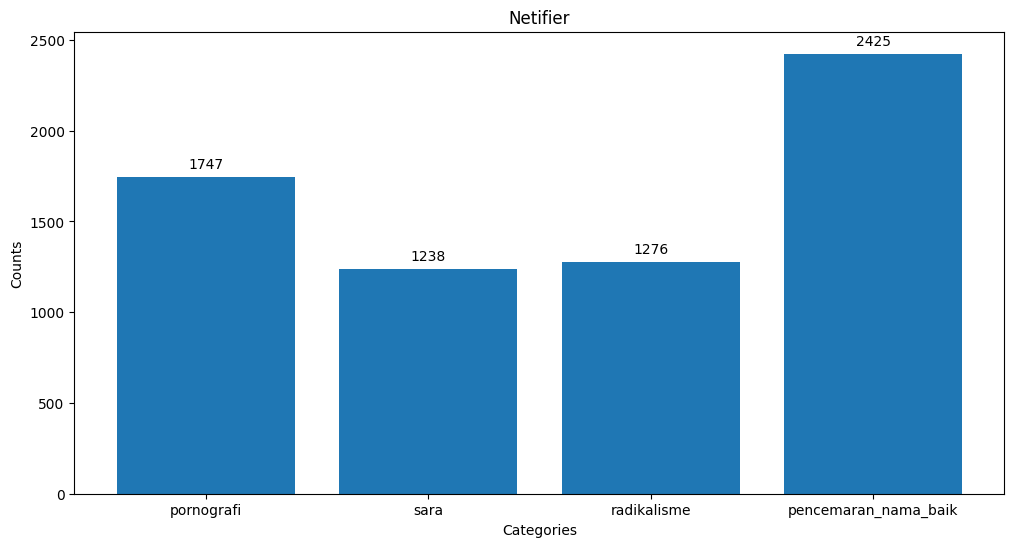

In [7]:
train_data = pd.read_csv('../processed/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('../processed/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], axis=0)
X = data["processed_text"]
y = data[data.columns[2:6]]

label_columns = data.columns[2:6]
print(label_columns)

label_count = count_label_occurences(data, label_columns)
print(label_count)

plot_data(label_count)

# Undersampling

In [20]:
data = pd.read_csv('../full_data.csv', encoding='latin-1')
# data.rename(columns={'processed_text': 'Tweet'}, inplace=True)
data.drop(columns=['source', 'original_text'], inplace=True)

column = ['processed_text', 'pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']
data = data[column]

In [21]:
# Downsample Pornografi and Pencemaran Nama Baik
pornografi_mask = (
    (data['pornografi'] == 1) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 1)
)
pornografi = data[pornografi_mask]
print("pornografi:", pornografi.shape)
pornografi_sampled = pornografi.sample(n=200, random_state=42)
non_pornografi = data[~pornografi_mask]
data = pd.concat([non_pornografi, pornografi_sampled], axis=0).reset_index(drop=True)

pornografi: (471, 5)


In [22]:
# Downsample Radikalisme and Pencemaran Nama Baik
radikalisme_pnb_mask = (
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 1) &
    (data['pencemaran_nama_baik'] == 1)
)
radikalisme_pnb = data[radikalisme_pnb_mask]
print("pnb:", radikalisme_pnb.shape)
radikalisme_pnb_sampled = radikalisme_pnb.sample(n=70, random_state=42)
non_radikalisme_pnb = data[~radikalisme_pnb_mask]
data = pd.concat([non_radikalisme_pnb, radikalisme_pnb_sampled], axis=0).reset_index(drop=True)

pnb: (108, 5)


In [23]:
# Downsample Pencemaran Nama Baik
pnb_mask = (
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 1)
)
pnb = data[pnb_mask]
print("pnb:", pnb.shape)
pnb_sampled = pnb.sample(n=300, random_state=42)
non_pnb = data[~pnb_mask]
data = pd.concat([non_pnb, pnb_sampled], axis=0).reset_index(drop=True)

pnb: (855, 5)


In [24]:
# Downsample Negative Samples
pnb_mask = (
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
)
pnb = data[pnb_mask]
print("pnb:", pnb.shape)
pnb_sampled = pnb.sample(n=1561, random_state=42)
non_pnb = data[~pnb_mask]
data = pd.concat([non_pnb, pnb_sampled], axis=0).reset_index(drop=True)

pnb: (3412, 5)


In [26]:
print("Oversampling SARA...")
sara = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 1) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
]
print(sara.shape)
translated = await back_translate_async(sara["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    sara["processed_text"].values[i] = translated[i]

Oversampling SARA...
(166, 5)


In [27]:
print("Oversampling Radikalisme...")
radikalisme = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 1) &
    (data['pencemaran_nama_baik'] == 0)
]
print(radikalisme.shape)
radikalisme = radikalisme.sample(n=323, random_state=42)
translated = await back_translate_async(radikalisme["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    radikalisme["processed_text"].values[i] = translated[i]

Oversampling Radikalisme...
(466, 5)


In [28]:
print("Oversampling Pornografi...")
pornografi = data[
    (data['pornografi'] == 1) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
]
print(pornografi.shape)
pornografi = pornografi.sample(n=85, random_state=42)
translated = await back_translate_async(pornografi["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    pornografi["processed_text"].values[i] = translated[i]

Oversampling Pornografi...
(1212, 5)


In [ ]:
data = pd.concat([data, sara, radikalisme, pornografi], axis=0).reset_index(drop=True)
data = pd.concat([data, sara], axis=0).reset_index(drop=True)

After: (5798, 5)
Index(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'], dtype='object')
{'pornografi': 1561, 'sara': 1570, 'radikalisme': 1561, 'pencemaran_nama_baik': 1561}
Imbalance ratios:
pornografi: 2.71
sara: 2.69
radikalisme: 2.71
pencemaran_nama_baik: 2.71
Mean imbalance ratio: 2.71
({'pornografi': 2.7142857142857144, 'sara': 2.6929936305732483, 'radikalisme': 2.7142857142857144, 'pencemaran_nama_baik': 2.7142857142857144}, 2.7089626933575977)


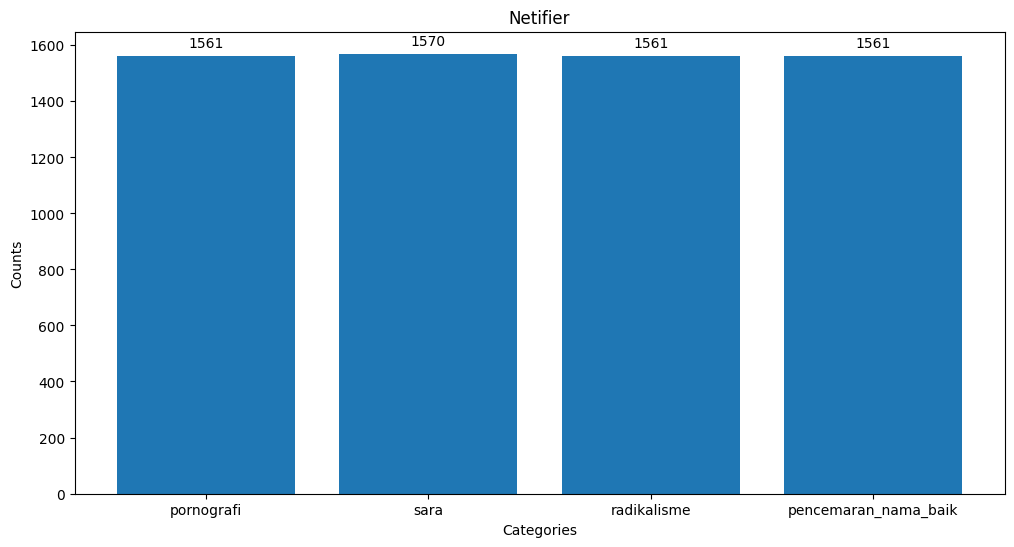

In [32]:
print("After:", data.shape)
label_columns = data.columns[1:]
print(label_columns)

aug_label_count = count_label_occurences(data, label_columns)
print(aug_label_count)

y = data[data.columns[1:]]
print(verify_imbalance_ratio(y))

plot_data(aug_label_count)

In [34]:
data.to_csv('./undersampled.csv', index=False)

# Oversampling

In [46]:
data = pd.read_csv('../full_data.csv', encoding='latin-1')
# data.rename(columns={'processed_text': 'Tweet'}, inplace=True)
data.drop(columns=['source', 'original_text'], inplace=True)

column = ['processed_text', 'pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']
data = data[column]

In [47]:
print("Oversampling Pornografi...")
pornografi = data[
    (data['pornografi'] == 1) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
]
print(pornografi.shape)
pornografi = pornografi.sample(n=678, random_state=42)
translated = await back_translate_async(pornografi["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    pornografi["processed_text"].values[i] = translated[i]

Oversampling Pornografi...
(1212, 5)


In [48]:
print("Oversampling SARA...")
sara = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 1) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
]
print(sara.shape)
translated = await back_translate_async(sara["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    sara["processed_text"].values[i] = translated[i]

Oversampling SARA...
(166, 5)


In [49]:
print("Oversampling Radikalisme...")
radikalisme = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 1) &
    (data['pencemaran_nama_baik'] == 0)
]
print(radikalisme.shape)
# radikalisme = radikalisme.sample(n=323, random_state=42)
translated = await back_translate_async(radikalisme["processed_text"].values.tolist(), target_lang='en', original_lang='id')

for i in range(len(translated)):
    radikalisme["processed_text"].values[i] = translated[i]

Oversampling Radikalisme...
(466, 5)


In [50]:
add_rad = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 1) &
    (data['pencemaran_nama_baik'] == 0)
]
add_rad = add_rad.sample(n=217, random_state=42)

ori_sara = data[
    (data['pornografi'] == 0) &
    (data['sara'] == 1) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
]

data = pd.concat([data, pornografi], axis=0).reset_index(drop=True)
data = pd.concat([data, add_rad], axis=0).reset_index(drop=True)

# Duplicate original data
for i in range(3):
    if i == 2:
        ori_sara = ori_sara.sample(n=25, random_state=42)
    data = pd.concat([data, ori_sara], axis=0).reset_index(drop=True)
    
# Duplicate back-translated data
for i in range(5):
    if i < 2:
        data = pd.concat([data, radikalisme], axis=0).reset_index(drop=True)
    data = pd.concat([data, sara], axis=0).reset_index(drop=True)

In [51]:
# Downsample Negative Samples
negative_mask = (
    (data['pornografi'] == 0) &
    (data['sara'] == 0) &
    (data['radikalisme'] == 0) &
    (data['pencemaran_nama_baik'] == 0)
)
negative = data[negative_mask]
print("negative:", negative.shape)
negative_sampled = negative.sample(n=2425, random_state=42)
non_negative = data[~negative_mask]
data = pd.concat([non_negative, negative_sampled], axis=0).reset_index(drop=True)

negative: (3412, 5)


After: (9800, 5)
Index(['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'], dtype='object')
{'pornografi': 2425, 'sara': 2425, 'radikalisme': 2425, 'pencemaran_nama_baik': 2425}
Imbalance ratios:
pornografi: 3.04
sara: 3.04
radikalisme: 3.04
pencemaran_nama_baik: 3.04
Mean imbalance ratio: 3.04
({'pornografi': 3.0412371134020617, 'sara': 3.0412371134020617, 'radikalisme': 3.0412371134020617, 'pencemaran_nama_baik': 3.0412371134020617}, 3.0412371134020617)


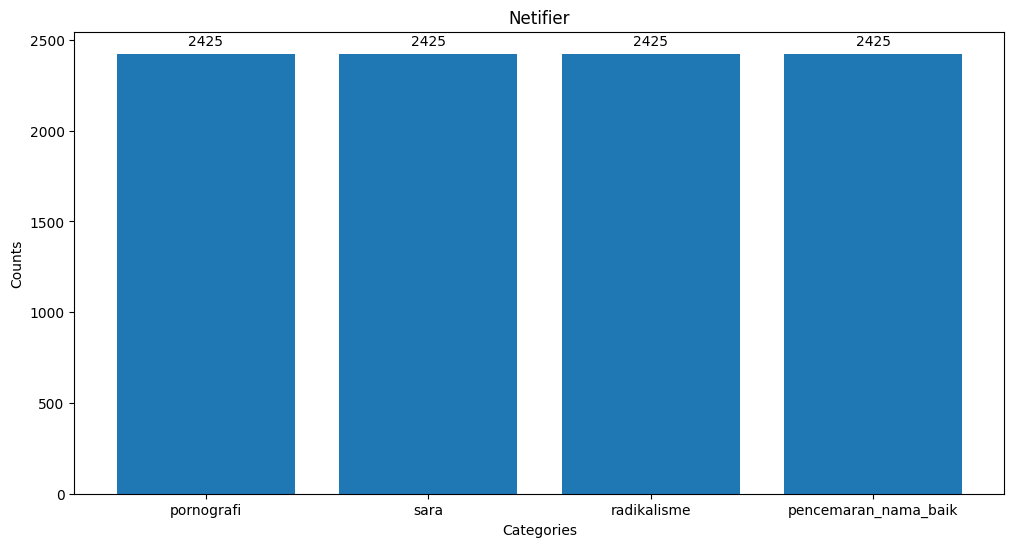

In [52]:
print("After:", data.shape)
label_columns = data.columns[1:]
print(label_columns)

aug_label_count = count_label_occurences(data, label_columns)
print(aug_label_count)

y = data[data.columns[1:]]
print(verify_imbalance_ratio(y))

plot_data(aug_label_count)

In [53]:
data.to_csv('./oversampled.csv', index=False)